#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 16
**CH16A Predicting apartment prices with random forest**

using the airbnb dataset

version 0.92 2021-07-05

In [1]:
import pandas as pd
import numpy as np

from patsy import dmatrices
from sklearn.model_selection import train_test_split
from skranger.ensemble import RangerForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import partial_dependence
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

## PART I
### Loading and preparing data 
----------------------------------------------

In [2]:
area = "bangkok"
data = pd.read_csv("../data/airbnb_" + area + "_workfile.csv")
data = data.loc[data.price.notna(), :]

In [3]:
def count_missing_values(df):
    return df.isna().sum()[df.isna().sum()>0]

In [4]:
count_missing_values(data)

Series([], dtype: int64)

In [5]:
# Sample definition and preparation ---------------------------------------

# We focus on normal apartments, n<8
data = data.query('2 <= n_accommodates <= 6')

In [6]:
# copy a variable - purpose later, see at variable importance
data = data.assign(n_accommodates_copy = data.n_accommodates)

In [7]:

# basic descr stat -------------------------------------------
data.describe()

,usd_price_day,p_host_response_rate,n_accommodates,n_review_scores_rating,n_number_of_reviews,n_reviews_per_month,n_minimum_nights,n_beds,n_days_since,d_airconditioning,...,flag_review_scores_rating,flag_reviews_per_month,flag_n_number_of_reviews,ln_days_since,ln_days_since2,ln_days_since3,n_days_since2,n_days_since3,ln_review_scores_rating,n_accommodates_copy
count,3627.000000,3627.0,3627.000000,3627.000000,3627.000000,3627.000000,3627.000000,3627.000000,3627.000000,3627.000000,...,3627.000000,3627.000000,3627.0,3627.000000,3627.000000,3627.000000,3.627000e+03,3.627000e+03,3627.000000,3627.000000
mean,679.064792,0.0,2.586986,4.663774,20.970499,0.666981,17.510339,1.237938,910.653708,0.979322,...,0.245106,0.245106,0.0,6.649400,44.644182,302.018658,1.088121e+06,1.658374e+09,-inf,2.586986
std,194.503709,0.0,0.883648,0.542642,42.424963,0.805605,44.203518,0.617286,508.824030,0.142324,...,0.430209,0.430209,0.0,0.655580,7.964334,76.233420,1.373715e+06,3.530946e+09,NaN,0.883648
min,269.000000,0.0,2.000000,0.000000,0.000000,0.010000,1.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.0,0.693147,0.480453,0.333025,1.000000e+00,1.000000e+00,-inf,2.000000
25%,500.000000,0.0,2.000000,4.650000,1.000000,0.220000,1.000000,1.000000,634.000000,1.000000,...,0.000000,0.000000,0.0,6.453625,41.649276,268.788806,4.019560e+05,2.548401e+08,1.536867,2.000000
50%,699.000000,0.0,2.000000,4.770000,4.000000,0.430000,2.000000,1.000000,790.000000,1.000000,...,0.000000,0.000000,0.0,6.673298,44.532906,297.181350,6.241000e+05,4.930390e+08,1.562346,2.000000
75%,850.000000,0.0,3.000000,4.900000,21.000000,0.780000,28.000000,1.000000,982.000000,1.000000,...,0.000000,0.000000,0.0,6.890609,47.480494,327.169525,9.643240e+05,9.469662e+08,1.589235,3.000000
max,999.000000,0.0,6.000000,5.000000,443.000000,15.370000,730.000000,6.000000,3848.000000,1.000000,...,1.000000,1.000000,0.0,8.255569,68.154414,562.653442,1.480710e+07,5.697774e+10,1.609438,6.000000


In [8]:
data.price.describe()

count    3627.000000
mean      679.064792
std       194.503709
min       269.000000
25%       500.000000
50%       699.000000
75%       850.000000
max       999.000000
Name: price, dtype: float64

In [9]:
data.f_property_type.value_counts()

Entire rental unit            1983
Entire condominium (condo)    1577
Entire serviced apartment       67
Name: f_property_type, dtype: int64

In [10]:
data.f_number_of_reviews.value_counts()

1    2304
0     889
2     434
Name: f_number_of_reviews, dtype: int64

In [11]:
# create train and holdout samples -------------------------------------------
# train is where we do it all, incl CV

# First pick a smaller than usual training set so that models run faster and check if works
# If works, start anew without these two lines

In [12]:
data_train, data_holdout = train_test_split(data, train_size=0.7, random_state=42)

In [13]:
data_train.shape, data_holdout.shape

((2538, 89), (1089, 89))

In [14]:
# Basic Variables inc neighnourhood
basic_vars = [
    "n_accommodates",
    "n_beds",
    "n_days_since",
    "f_property_type",
    "f_neighbourhood_cleansed",
]

# reviews
reviews = [
    "n_number_of_reviews",
    "flag_n_number_of_reviews",
    "n_review_scores_rating",
    "flag_review_scores_rating",
]

# Dummy variables
amenities = [col for col in data if col.startswith("d_")]

# interactions for the LASSO
# from ch14
X1 = [
    "n_accommodates:f_property_type",
    "n_accommodates:d_longtermstaysallowed",
    "d_breakfast:f_property_type",
    "d_kitchen:f_property_type",
    "d_elevator:f_property_type",
    "d_essentials:f_property_type"
]
# with boroughs
X2 = [
    "f_property_type:f_neighbourhood_cleansed",
    #"f_room_type:f_neighbourhood_cleansed",
    "n_accommodates:f_neighbourhood_cleansed",
]

In [15]:
data.d_bathtub.value_counts()

0    3508
1     119
Name: d_bathtub, dtype: int64

In [16]:
predictors_1 = basic_vars
predictors_2 = basic_vars + reviews + amenities
predictors_E = basic_vars + reviews + amenities + X1 + X2

## PART II
### RANDOM FORESTS 
-------------------------------------------------------

In [17]:
rfr = RangerForestRegressor(importance="impurity",seed = 42)

tune_grid = {"mtry": [5, 7, 9], "min_node_size": [5, 10]}

rf_random = GridSearchCV(
    rfr,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

y, X = dmatrices("price ~ " + " + ".join(predictors_1), data_train)

rf_model_1 = rf_random.fit(X, y.ravel())

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ........min_node_size=5, mtry=5;, score=-183.842 total time=   0.3s
[CV 2/5] END ........min_node_size=5, mtry=5;, score=-172.863 total time=   0.2s
[CV 3/5] END ........min_node_size=5, mtry=5;, score=-169.477 total time=   0.2s
[CV 4/5] END ........min_node_size=5, mtry=5;, score=-169.914 total time=   0.2s
[CV 5/5] END ........min_node_size=5, mtry=5;, score=-172.206 total time=   0.2s
[CV 1/5] END ........min_node_size=5, mtry=7;, score=-181.882 total time=   0.3s
[CV 2/5] END ........min_node_size=5, mtry=7;, score=-170.047 total time=   0.3s
[CV 3/5] END ........min_node_size=5, mtry=7;, score=-168.002 total time=   0.3s
[CV 4/5] END ........min_node_size=5, mtry=7;, score=-168.752 total time=   0.2s
[CV 5/5] END ........min_node_size=5, mtry=7;, score=-168.502 total time=   0.2s
[CV 1/5] END ........min_node_size=5, mtry=9;, score=-180.606 total time=   0.3s
[CV 2/5] END ........min_node_size=5, mtry=9;, sc

In [18]:
rfr = RangerForestRegressor(importance="impurity",seed = 42)

tune_grid = {"mtry": [8, 10, 12], "min_node_size": [5, 10, 15]}

rf_random = GridSearchCV(
    rfr,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

y, X = dmatrices("price ~ " + " + ".join(predictors_2), data_train)

rf_model_2 = rf_random.fit(X,y.ravel())

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END ........min_node_size=5, mtry=8;, score=-154.935 total time=   0.4s
[CV 2/5] END ........min_node_size=5, mtry=8;, score=-145.074 total time=   0.5s
[CV 3/5] END ........min_node_size=5, mtry=8;, score=-143.711 total time=   0.4s
[CV 4/5] END ........min_node_size=5, mtry=8;, score=-145.572 total time=   0.3s
[CV 5/5] END ........min_node_size=5, mtry=8;, score=-146.757 total time=   0.3s
[CV 1/5] END .......min_node_size=5, mtry=10;, score=-153.710 total time=   0.3s
[CV 2/5] END .......min_node_size=5, mtry=10;, score=-143.862 total time=   0.5s
[CV 3/5] END .......min_node_size=5, mtry=10;, score=-142.305 total time=   0.3s
[CV 4/5] END .......min_node_size=5, mtry=10;, score=-145.228 total time=   0.3s
[CV 5/5] END .......min_node_size=5, mtry=10;, score=-146.051 total time=   0.5s
[CV 1/5] END .......min_node_size=5, mtry=12;, score=-151.722 total time=   0.9s
[CV 2/5] END .......min_node_size=5, mtry=12;, sc

### Table 16.1 Random forest RMSE by tuning parameters

In [19]:
pd.DataFrame(rf_model_2.cv_results_)[
    ["param_mtry", "param_min_node_size", "mean_test_score"]
].assign(
    mean_test_score=lambda x: x["mean_test_score"] * -1,
    Variables=lambda x: x["param_mtry"],
    Min_nodes=lambda x: x["param_min_node_size"],
).pivot(
    index="Min_nodes", columns="Variables", values="mean_test_score"
).round(
    2
)

Variables,8,10,12
Min_nodes,,,
5,147.21,146.23,145.51
10,148.32,147.45,147.32
15,149.68,149.13,148.50


In [20]:
pd.DataFrame(
    {
        "Min vars": [rf_model_1.best_estimator_.mtry, rf_model_2.best_estimator_.mtry],
        "Min nodes": [
            rf_model_1.best_estimator_.min_node_size,
            rf_model_2.best_estimator_.min_node_size,
        ],
    },
    ["Model A", "Model B"],
)

,Min vars,Min nodes
Model A,9,10
Model B,12,5


In [27]:
pd.DataFrame(
    {
        "RMSE": [
            np.min(rf_model_1.cv_results_["mean_test_score"]*-1),
            np.min(rf_model_2.cv_results_["mean_test_score"]*-1),
        ]
    },
    ["Model A", "Model B"],
).round(3)

,RMSE
Model A,169.929
Model B,145.511


## PART III
### MODEL DIAGNOSTICS 
---

In [28]:
rf_model_2_var_imp_df = (
    pd.DataFrame(
        rf_model_2.best_estimator_.feature_importances_, X.design_info.column_names
    )
    .reset_index()
    .rename({"index": "varname",0: "imp"}, axis=1)
    .assign(imp_percentage=lambda x: x["imp"] / x["imp"].sum())
    .sort_values(by=["imp"], ascending=False)
)

**1) full varimp plot, above a cutoff**

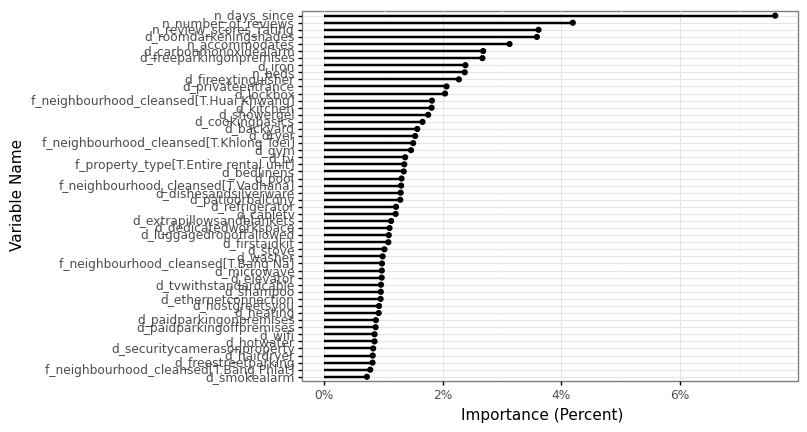

<ggplot: (310361679)>

In [31]:
cutoff = 600000

ggplot(
    rf_model_2_var_imp_df.loc[lambda x: x.imp > cutoff],
    aes(x="reorder(varname, imp)", y="imp_percentage"),
) + geom_point(size=1.5) + geom_segment(
    aes(x="varname", xend="varname", y=0, yend="imp_percentage"), size=1
) + ylab(
    "Importance (Percent)"
) + xlab(
    "Variable Name"
) + coord_flip() + scale_y_continuous(
    labels=percent_format()
) + theme_bw()

**2) full varimp plot, top 10 only**

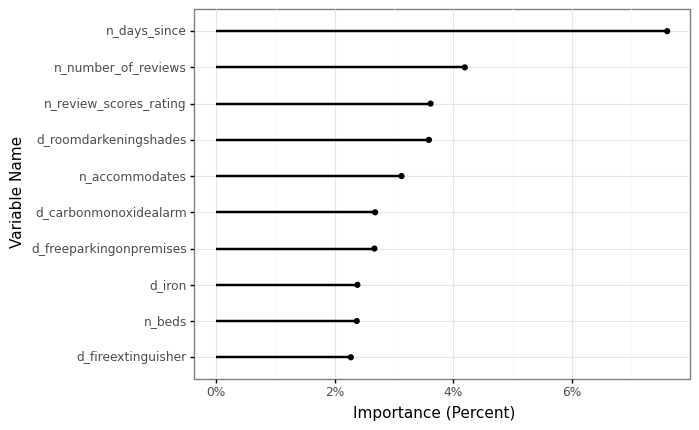

<ggplot: (310987873)>

In [32]:
ggplot(
    rf_model_2_var_imp_df.iloc[:10, :],
    aes(x="reorder(varname, imp)", y="imp_percentage"),
) + geom_point(size=1.5) + geom_segment(
    aes(x="varname", xend="varname", y=0, yend="imp_percentage"), size=1
) + ylab(
    "Importance (Percent)"
) + xlab(
    "Variable Name"
) + coord_flip() + scale_y_continuous(
    labels=percent_format()
) + theme_bw()

**3) grouped variable importance - keep binaries created off factors together**

For this, you need to create an sklearn pipeline and put OneHotEncoding in it (before, encoding was done by patsy's dmatrices). This way permutation_importance can calculate factor variables' importance 

In [33]:
categorical_columns = [col for col in predictors_2 if col.startswith("f_")]
numerical_columns = [col for col in predictors_2 if col not in categorical_columns]

In [34]:
categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", "passthrough", numerical_columns),
    ]
)

rf = Pipeline(
    [("preprocess", preprocessing), ("regressor", rf_model_2.best_estimator_)] # put best model to pipeline
)

In [35]:
rf.fit(data_train[predictors_2],data_train.price)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['f_property_type',
                                                   'f_neighbourhood_cleansed']),
                                                 ('num', 'passthrough',
                                                  ['n_accommodates', 'n_beds',
                                                   'n_days_since',
                                                   'n_number_of_reviews',
                                                   'flag_n_number_of_reviews',
                                                   'n_review_scores_rating',
                                                   'flag_review_scores_rating',
                                                   'd_airconditioning',
                                                   'd_longte...
       

In [36]:
# this takes a while to run
result = permutation_importance(
    rf,
    data_train[predictors_2],
    data_train.price,
    n_repeats=10,
    random_state=45,
)

In [37]:
categorical_columns

['f_property_type', 'f_neighbourhood_cleansed']

In [39]:
grouped = [
    "f_property_type",
    "n_days_since",
    "n_accommodates",
    "n_beds",
    "f_neighbourhood_cleansed",
]
grouped_imp = (
    pd.DataFrame(
        result.importances_mean,
        data_train[predictors_2].columns,
    )
    .loc[grouped]
    .reset_index()
    .rename({"index": "varname", 0: "imp"}, axis=1)
    .assign(imp_percentage=lambda x: x["imp"] / x["imp"].sum())
    .sort_values(by=["imp"], ascending=False)
)

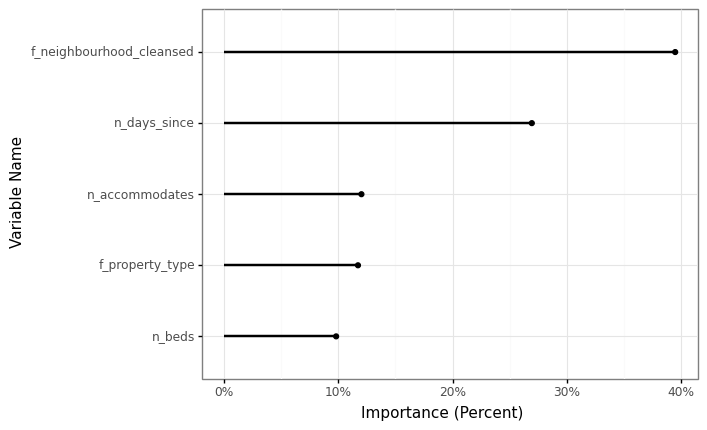

<ggplot: (310562910)>

In [42]:
ggplot(grouped_imp, aes(x="reorder(varname, imp)", y="imp_percentage"),) + geom_point( size=1.5
) + geom_segment(
    aes(x="varname", xend="varname", y=0, yend="imp_percentage"), size=1
) + ylab(
    "Importance (Percent)"
) + xlab(
    "Variable Name"
) + coord_flip() + scale_y_continuous(
    labels=percent_format()
) + theme_bw()

## Partial Dependence Plots 
-------------------------------------------------------


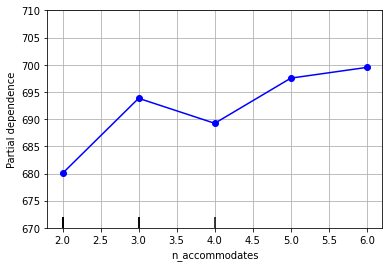

In [47]:
# Note: easy way, sklearn has plot_partial_dependence function
# we do this on holdout set!
plot_partial_dependence(
    rf,
    data_holdout[predictors_2],
    ["n_accommodates"],
    feature_names=data_holdout[predictors_2].columns,
    line_kw={"marker": "o", "color": "blue"},
)
plt.grid()
plt.ylim(670, 710)
plt.show()

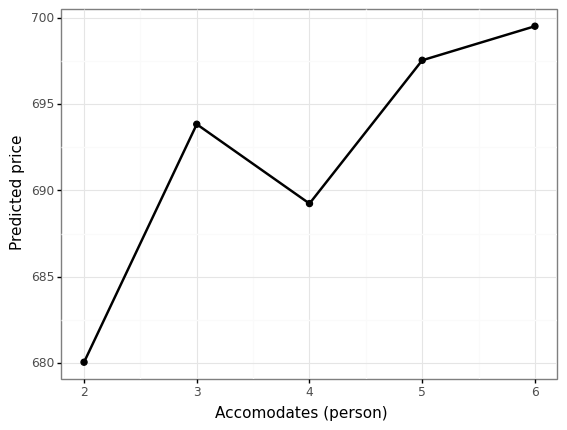

<ggplot: (310697834)>

In [49]:
# replicate the exact book figure with plotnine
accom_pdp = partial_dependence(
    rf, data_holdout[predictors_2], ["n_accommodates"], kind="average"
)

accom_pdp = (
    pd.DataFrame(accom_pdp["average"], columns=accom_pdp["values"][0].tolist())
    .T.reset_index()
    .rename({0: "Predicted price", "index": "Accomodates (person)"}, axis=1)
)

ggplot(accom_pdp, aes(x="Accomodates (person)", y="Predicted price")) + geom_point( size=2
) + geom_line( size=1) + scale_x_continuous(
    breaks=range(1, 8)
) + theme_bw()

### Subsample performance: RMSE / mean(y) 
---------------------------------------
NOTE  we do this on the holdout set.


In [51]:
data_holdout_w_prediction = data_holdout.assign(
    predicted_price=rf.predict(data_holdout[predictors_2])
)

create nice summary table of heterogeneity

In [52]:
from sklearn.metrics import mean_squared_error


def calculate_rmse(groupby_obj):
    return (
        groupby_obj.apply(
            lambda x: mean_squared_error(x.predicted_price, x.price, squared=False),
        )
        .to_frame(name="rmse")
        .assign(mean_price=groupby_obj.apply(lambda x: np.mean(x.price)).values)
        .assign(rmse_norm=lambda x: x.rmse / x.mean_price).round(2)
    )

In [53]:
# cheaper or more expensive flats - not used in book
grouped_object = data_holdout_w_prediction.assign(
    is_low_size=lambda x: np.where(x.n_accommodates <= 3, "small apt", "large apt")
).groupby("is_low_size")
accom_subset = calculate_rmse(grouped_object)

In [60]:
data.f_neighbourhood_cleansed.value_counts().head(10).index().tolist()

TypeError: 'Index' object is not callable

In [59]:
grouped_object = data_holdout_w_prediction.loc[
    lambda x: x.f_neighbourhood_cleansed.isin(data.f_neighbourhood_cleansed.value_counts().head(10).index.tolist())
].groupby("f_neighbourhood_cleansed")
neightbourhood_subset = calculate_rmse(grouped_object)

In [62]:
all_holdout = pd.DataFrame(
    [
        mean_squared_error(
            data_holdout_w_prediction.price,
            data_holdout_w_prediction.predicted_price,
            squared=False,
        ),
        data_holdout_w_prediction.price.mean(),
    ],
    index=["rmse", "mean_price"],
).T.assign(rmse_norm=lambda x: x.rmse / x.mean_price)
all_holdout.index = ["All"]

In [66]:
type_rows = pd.DataFrame(
    None,
    index=["Apartment size", "Borough"],
    columns=["rmse", "mean_price", "rmse_norm"],
).fillna("")

### Table 16.2 Performance across subsamples

In [68]:
pd.concat(
    [
        type_rows.iloc[[0]],
        accom_subset,
        type_rows.iloc[[1]],
        neightbourhood_subset,
        all_holdout,
    ]
)

,rmse,mean_price,rmse_norm
Apartment size,,,
large apt,143.08,668.27,0.21
small apt,141.79,686.42,0.21
Borough,,,
Bang Na,188.5,597.38,0.32
Bang Sue,154.25,674.58,0.23
Chatu Chak,130.12,756.23,0.17
Din Daeng,127.6,758.0,0.17
Huai Khwang,141.95,651.87,0.22
Khlong Toei,117.59,651.74,0.18


## PART IV
### HORSERACE: compare with other models 
-----------------------------------------------
**NOTE: this part of the code is not finished**

1. OLS with dummies for area

 using model B

In [69]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [70]:
y, X = dmatrices("price ~ " + " + ".join(predictors_2), data_train)

ols_model = LinearRegression().fit(X,y)

#y_test, X_test = dmatrices("price ~ " + " + ".join(predictors_2), data_holdout)

y_hat = ols_model.predict(X)

ols_rmse = mean_squared_error(y,y_hat,squared=False)
ols_rmse

157.04410229200752

In [71]:
ols_model_coeffs_df = pd.DataFrame(
    ols_model.coef_.tolist()[0],
    index=X.design_info.column_names,
    columns=["ols_coefficient"],
).assign(ols_coefficient=lambda x: x.ols_coefficient.round(3))

In [72]:
ols_model_coeffs_df

,ols_coefficient
Intercept,0.000
f_property_type[T.Entire rental unit],11.811
f_property_type[T.Entire serviced apartment],50.540
f_neighbourhood_cleansed[T.Bang Khae],-100.439
f_neighbourhood_cleansed[T.Bang Khen],-45.909
...,...
d_hotwaterkettle,34.539
d_keypad,13.671
d_bathtub,44.927
d_singlelevelhome,53.860


2.  LASSO

using extended model w interactions

In [73]:
from sklearn.linear_model import ElasticNet

The parameter l1_ratio corresponds to alpha in the glmnet R package while alpha corresponds to the lambda parameter in glmnet. Specifically, l1_ratio = 1 is the lasso penalty. Currently, l1_ratio <= 0.01 is not reliable, unless you supply your own sequence of alpha.

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html

In [74]:
lasso_model =  ElasticNet(l1_ratio = 1,normalize=True,fit_intercept=True)

In [75]:
lasso_model_cv = GridSearchCV(
    lasso_model,
    {"alpha":[i/100 for i in range(1, 26, 1)]},
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)


In [76]:
y, X = dmatrices("price ~ " + " + ".join(predictors_E), data_train)

In [77]:
lasso_model_cv.fit(X, y.ravel())

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END .....................alpha=0.01;, score=-172.708 total time=   0.1s
[CV 2/5] END .....................alpha=0.01;, score=-162.493 total time=   0.2s
[CV 3/5] END .....................alpha=0.01;, score=-163.747 total time=   0.1s
[CV 4/5] END .....................alpha=0.01;, score=-161.200 total time=   0.1s
[CV 5/5] END .....................alpha=0.01;, score=-166.638 total time=   0.1s
[CV 1/5] END .....................alpha=0.02;, score=-172.322 total time=   0.1s
[CV 2/5] END .....................alpha=0.02;, score=-163.089 total time=   0.0s
[CV 3/5] END .....................alpha=0.02;, score=-163.433 total time=   0.0s
[CV 4/5] END .....................alpha=0.02;, score=-160.484 total time=   0.1s
[CV 5/5] END .....................alpha=0.02;, score=-163.796 total time=   0.1s
[CV 1/5] END .....................alpha=0.03;, score=-172.170 total time=   0.1s
[CV 2/5] END .....................alpha=0.03;, 

[CV 3/5] END .....................alpha=0.22;, score=-164.385 total time=   0.0s
[CV 4/5] END .....................alpha=0.22;, score=-168.957 total time=   0.0s
[CV 5/5] END .....................alpha=0.22;, score=-168.676 total time=   0.0s
[CV 1/5] END .....................alpha=0.23;, score=-177.951 total time=   0.0s
[CV 2/5] END .....................alpha=0.23;, score=-169.301 total time=   0.0s
[CV 3/5] END .....................alpha=0.23;, score=-164.644 total time=   0.0s
[CV 4/5] END .....................alpha=0.23;, score=-169.319 total time=   0.0s
[CV 5/5] END .....................alpha=0.23;, score=-169.261 total time=   0.0s
[CV 1/5] END .....................alpha=0.24;, score=-178.320 total time=   0.0s
[CV 2/5] END .....................alpha=0.24;, score=-169.588 total time=   0.0s
[CV 3/5] END .....................alpha=0.24;, score=-164.921 total time=   0.0s
[CV 4/5] END .....................alpha=0.24;, score=-169.676 total time=   0.0s
[CV 5/5] END ...............

GridSearchCV(cv=5, estimator=ElasticNet(l1_ratio=1, normalize=True),
             param_grid={'alpha': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07,
                                   0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14,
                                   0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21,
                                   0.22, 0.23, 0.24, 0.25]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [78]:
pd.DataFrame(
    lasso_model_cv.best_estimator_.coef_.tolist(),
    index=X.design_info.column_names,
    columns=["lasso_coefficient"],
).assign(lasso_coefficient=lambda x: x.lasso_coefficient.round(3)).loc[
    lambda x: x.lasso_coefficient != 0
]

,lasso_coefficient
f_neighbourhood_cleansed[T.Bang Khae],-45.069
f_neighbourhood_cleansed[T.Bang Kho laen],0.200
f_neighbourhood_cleansed[T.Bang Khun thain],-4.585
f_neighbourhood_cleansed[T.Bang Na],-27.460
f_neighbourhood_cleansed[T.Bang Phlat],-81.722
...,...
d_hotwaterkettle,9.603
d_keypad,0.408
d_bathtub,40.910
d_singlelevelhome,48.073


In [79]:
lasso_rmse = pd.DataFrame(lasso_model_cv.cv_results_).loc[
    lambda x: x.param_alpha == lasso_model_cv.best_estimator_.alpha
].mean_test_score.values[0] * -1
lasso_rmse

164.21569656046614

3. CART model

In [80]:
from sklearn.tree import DecisionTreeClassifier

In [81]:
y, X = dmatrices("price ~ " + " + ".join(predictors_2), data_train)

In [82]:
cart_model = DecisionTreeClassifier(random_state=2018, criterion="gini")

In [83]:
# Get potential ccp_alpha parameters

path = cart_model.cost_complexity_pruning_path(X, y.ravel())
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [84]:
# apply random search to select a "best" alpha 
# RandomizedSearchCV does not calculate all potential alphas, just a random subset

cart_model_cv = RandomizedSearchCV(
    cart_model,
    {"ccp_alpha":ccp_alphas},
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)


cart_model_cv.fit(X,y.ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END ccp_alpha=0.0006129060502582961;, score=-256.253 total time=   0.1s


/Users/vigadam/.local/share/virtualenvs/Assignment_2-7CJqppZW/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.


[CV 2/5] END ccp_alpha=0.0006129060502582961;, score=-221.947 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0006129060502582961;, score=-234.076 total time=   0.2s
[CV 4/5] END ccp_alpha=0.0006129060502582961;, score=-236.717 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0006129060502582961;, score=-239.093 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0003940110323089047;, score=-210.843 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0003940110323089047;, score=-198.147 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0003940110323089047;, score=-219.228 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0003940110323089047;, score=-221.510 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0003940110323089047;, score=-214.348 total time=   0.1s
[CV 1/5] END ccp_alpha=0.0003940110323089047;, score=-210.843 total time=   0.2s
[CV 2/5] END ccp_alpha=0.0003940110323089047;, score=-198.147 total time=   0.2s
[CV 3/5] END ccp_alpha=0.0003940110323089047;, score=-219.228 total time=   0.1s
[CV 4/5] END ccp_alpha=0.000

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=2018),
                   param_distributions={'ccp_alpha': array([0.00000000e+00, 6.56685054e-05, 1.31337011e-04, 1.31337011e-04,
       1.31337011e-04, 1.50099441e-04, 1.97005516e-04, 2.62674022e-04,
       2.95508274e-04, 2.95508274e-04, 2.95508274e-04, 2.95508274e-04,
       2.95508274e-04, 3.06453025e-04, 3.15208826e-04, 3.1520882...
       1.32212591e-03, 1.33547229e-03, 1.39162408e-03, 1.40546618e-03,
       1.41439858e-03, 1.41754291e-03, 1.43362893e-03, 1.49597772e-03,
       1.55589502e-03, 1.68031101e-03, 1.74021539e-03, 1.79229650e-03,
       2.18971992e-03, 2.30838026e-03, 2.41732562e-03, 2.42469024e-03,
       2.86484888e-03, 3.87891405e-03, 4.36998259e-03, 4.70288338e-03,
       6.81983312e-03, 7.10191545e-03])},
                   scoring='neg_root_mean_squared_error', verbose=3)

In [85]:
cart_rmse = pd.DataFrame(cart_model_cv.cv_results_).loc[
    lambda x: x.param_ccp_alpha == cart_model_cv.best_estimator_.ccp_alpha
].mean_test_score.values[0] * -1
cart_rmse

200.55896773747577